# SCC.413 Applied Data Mining
# Week 18
# Classification 2 (using custom Document)

## Contents
* [Introduction](#intro)
* [Preamble](#preamble)
* [Document object](#doc)
    - [Dataset](#data)
    - [Document processor](#processor)
* [Feature Union](#union)
* [Classifying other labels](#other)
* [Exercise (not assessed)](#ex)

<a id="intro"></a>
## Introduction

In the the first classification exercise scikit-learn was used to classify Twitter users as male or female. Vectorization was done via sklearn's CountVectorizer. At the end of the lab exercise, the preprocessing and tokenisation used by CountVectorizer were customised to give greater control of how the text was processed and features extracted. This actually allows for quite a number of features to be implemented, e.g.:

- POS tags, by pos-tagging during tokenisation, and returning the pos-tags instead of words.
- Function words, by setting the vocabulary of CountVectorizer to a function word list.
- Hashtags, mentions and/or emojis, by only returning these in the token list.
- Characters/graphemes, rather than codepoints, by "tokenising" with "\X".

But we are limited to counting things. Another issue is that the processing will be done multiple times each time the pipeline is ran (e.g. for gridsearch).

In this lab you will learn how to process texts in advance, saving the token lists and frequency lists produced, and allowing for other features to be extracted.

<a id="preamble"></a>
## Preamble

First, we do all the imports needed in one go. You may import other packages as needed.

In [1]:
import ftfy
import nltk
import json

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Binarizer, StandardScaler

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import re

from collections import Counter
from os import listdir, makedirs
from os.path import isfile, join, splitext, split

A couple of functions for showing classifier results (from first classification lab):

In [2]:
def print_cv_scores_summary(name, scores):
    print("{}: mean = {:.2f}%, sd = {:.2f}%, min = {:.2f}, max = {:.2f}".format(name, scores.mean()*100, scores.std()*100, scores.min()*100, scores.max()*100))
    
def confusion_matrix_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    dims = (5, 5)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(cmdf, annot=True, cmap="coolwarm", center=0)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')

<a id="doc"></a>
## Document object

Next we define our document object, along with preprocessing tokenisation methods. These are taken (and slightly extended) from the Feature Extraction lab. The document will represent an instance in our classifier, e.g. it could be a collection of a user's Tweets, a single tweet, a longer article, etc.

In [3]:
hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")

def preprocess(text):
    p_text = hashtag_re.sub("[hashtag]",text)
    p_text = mention_re.sub("[mention]",p_text)
    p_text = url_re.sub("[url]",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text

tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)
def tokenise(text):
    return tokenise_re.findall(text)

class Document:
    def __init__(self, meta={}):
        self.meta = meta
        self.tokens_fql = Counter() #empty Counter, ready to be added to with Counter.update.
        self.ht_fql = Counter()
        self.num_tokens = 0
        
    def extract_features_from_text(self, text):
        hts = hashtag_re.findall(text)
        self.ht_fql.update([ht.lower() for ht in hts])
        p_text = preprocess(text)
        tokens = tokenise(p_text)
        lower_tokens = [t.lower() for t in tokens]
        self.num_tokens += len(lower_tokens)
        self.tokens_fql.update(lower_tokens) #updating Counter counts items in list, adding to existing Counter items.
        
    def extract_features_from_texts(self, texts): #texts should be iterable text lines, e.g. read in from file.
        for text in texts:
            extract_features_from_text(text)
            
    def average_token_length(self):
        sum_lengths = 0
        for key, value in self.tokens_fql.items():
            sum_lengths += len(key) * value
        return sum_lengths / self.num_tokens

<a id="data"></a>
### Dataset

We use the Twitter celebs again (this time with extra users from around the world), but from JSON files with further metadata available (the data is slightly different from the first classification lab as it was collected later). The method below reads in the json file, extracts the metadata for the user, creates a new Document representing the user, and adds all of the Tweets (extracting features).

In [4]:
def import_celebs_json(folder):
    jsonfiles = [join(folder, f) for f in listdir(folder) if isfile(join(folder, f)) and f.endswith(".json")]
    for jf in jsonfiles:
        with open(jf) as f:
            data = json.load(f)
            handle = data['handle']
            gender = data['gender']
            age_range = data['age_range']
            english = data['english']
        print("Processing " + handle)
        doc = Document(meta={'handle': handle, 'gender': gender, 'age_range': age_range, 'english': english}) #include metadata
        for tweet in data['tweets']:
            doc.extract_features_from_text(tweet['text'])
        yield doc

Build the corpus by processing the folder of celebs. This will take a little while, but it should only need doing once (unless you change the Document class).

In [5]:
corpus = []
corpus.extend(import_celebs_json("celebs-json"))

Processing KellyOsbourne
Processing yannicklawry
Processing NathanFillion
Processing geneliad
Processing vkhosla
Processing ajaydevgn
Processing GulPanag
Processing garyvee
Processing PadmaLakshmi
Processing WilliamShatner
Processing JesseLumsden28
Processing Richard_H
Processing Peter_Max
Processing JohnCleese
Processing howardlindzon
Processing robbiewilliams
Processing anandmahindra
Processing eddievanhalen
Processing PaulMcCartney
Processing karanjohar
Processing LucasdiGrassi
Processing SteveNash
Processing virsanghvi
Processing iyavillania
Processing vikramchandra
Processing clinton_kelly
Processing LisaHannigan
Processing RobbieHunter
Processing GabrielSaporta
Processing camanpour
Processing kenghosh
Processing ashabhosle
Processing ameesha_patel
Processing richardbranson
Processing JoeySantiago
Processing itspetergabriel
Processing AnupamPKher
Processing Jonnyboy77
Processing Winter
Processing bobbyllew
Processing charlesarthur
Processing Goldsack
Processing Sia
Processing Beve

We use the gender metadata from the Documents as our label/class.

In [6]:
y = [d.meta['gender'] for d in corpus]
X = corpus

We can also perform the usual train/test split.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0, stratify=y)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

223 56
223 56


<a id="processor"></a>
### Document processor

Now we have our train/test instances in our custom class to hold the features, we need to build a custom `Transformer` which takes in one dataset and returns a new dataset. Here we need to take in a list of `Document` objects and transform it into a set of features. We build a simple class for this, which overrides the transform method. The intention is for a list of `Document` objects to be passed into the transformer, and a parameter-defined (callable) method is used to extract the featuress.

In [8]:
class DocumentProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, process_method):
        self.process_method = process_method
    
    def fit(self, X, y=None): #no fitting necessary, although could use this to build a vocabulary for all documents, and then limit to set (e.g. top 1000).
        return self

    def transform(self, documents):
        for document in documents:
            yield self.process_method(document)

Below are some example methods for returning the token frequency list, hashtag frequency list, or some text statistics from the `Document`. These can be edited and added to as needed.

In [9]:
def get_tokens_fql(document):
    return document.tokens_fql

def get_ht_fql(document):
    return document.ht_fql

def get_text_stats(document):
    ttr = len(document.tokens_fql) / document.num_tokens
    return {'avg_token_length': document.average_token_length(), 'ttr': ttr }

def read_list(file):
    with open(file) as f:
        items = []
        lines = f.readlines()
        for line in lines:
            items.append(line.strip())
    return items

fws = read_list("functionwords.txt")

def get_fws_fql(document):
    fws_fql = Counter({t: document.tokens_fql[t] for t in fws}) #dict comprehension, t: fql[t] is token: freq.
    return +fws_fql

We build a pipeline with the `DocumentProcessor` as the first step, extract hashtag frequencies as features. The output from the new `DocumentProcessor` is then passed to a [`DictVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html#sklearn.feature_extraction.DictVectorizer), which transforms the features into a vector (scipy.sparse matrix), which can be used with other sklearn steps. To demontrate, we pass to a logistic regression classifier.

In [10]:
model = Pipeline([
    ('processor', DocumentProcessor(process_method = get_ht_fql)),
    ('vectorizer', DictVectorizer()),
    ('standardize', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
])

In [11]:
cv_scores = cross_validate(model, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print_cv_scores_summary("Accuracy", cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", cv_scores['test_f1_weighted'])

Accuracy: mean = 73.84%, sd = 3.83%, min = 67.86, max = 78.57
Precision: mean = 71.34%, sd = 8.75%, min = 58.47, max = 82.48
Recall: mean = 73.84%, sd = 3.83%, min = 67.86, max = 78.57
F1: mean = 68.37%, sd = 4.35%, min = 61.57, max = 74.38


<a id="union"></a>
## Feature Union

All the pipelines we have used so far have been simple linear sequences of steps. With [`FeatureUnion`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion) we can have complex branched sequences, where different features, or different parts of the text are processed separately. The results are then concatenated together into a composite vector. We could, for example, read in a user's bio separately from the rest of their text, we could even utilise metadata (such as usernames to predict gender), or other data such as profile images.

Below we utilise different featuresets available from the Document instances and concatenate them together simply.

In [12]:
model = Pipeline([
    ('text_union', FeatureUnion(
        transformer_list = [
            ('ht_features', Pipeline([
                ('ht_processor', DocumentProcessor(process_method = get_ht_fql)),
                ('ht_vectorizer', DictVectorizer()),
            ])),
            ('fws_features', Pipeline([
                ('fws_processor', DocumentProcessor(process_method = get_fws_fql)),
                ('fws_vectorizer', DictVectorizer()),
            ])),
            ('stats_features', Pipeline([
                ('stats_processor', DocumentProcessor(process_method = get_text_stats)),
                ('stats_vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('standardize', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
])

In [13]:
cv_scores = cross_validate(model, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print_cv_scores_summary("Accuracy", cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", cv_scores['test_f1_weighted'])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: mean = 72.76%, sd = 3.07%, min = 69.64, max = 78.57
Precision: mean = 63.14%, sd = 11.72%, min = 51.02, max = 83.42
Recall: mean = 72.76%, sd = 3.07%, min = 69.64, max = 78.57
F1: mean = 64.49%, sd = 4.76%, min = 59.52, max = 72.80


<a id="other"></a>
## Classifying other labels

We have been working on binary classification of gender. Other user metadata can be predicted also, with the age_range and English variety being present (if you use the larger datasets provided).

Looking at age, there are 5 age ranges present, plus some marked as "unknown". We need to remove the "unknowns" as predicting as 'unknown' does not make sense. You could predict these unknowns with your trained classifier at the end.

In [14]:
set([d.meta['age_range'] for d in X])

{'25-34', '35-44', '45-54', '55-64', '65+', 'unknown'}

In [15]:
age_X = [d for d in X if d.meta['age_range'] != 'unknown']

In [16]:
len(age_X)

267

12 instances have been removed. We need to extract the new labels also.

In [17]:
age_y = [d.meta['age_range'] for d in age_X]

We do a train-test split as before.

In [18]:
age_X_train, age_X_test, age_y_train, age_y_test = train_test_split(age_X, age_y, test_size=0.2, random_state = 0, stratify=age_y)

We build a pipeline with feature union similar to earlier, except we are now also using grid search, including if to include function words or all words.

In [19]:
model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('ht', Pipeline([
                ('processor', DocumentProcessor(process_method = get_ht_fql)),
                ('vectorizer', DictVectorizer()),
            ])),
            ('word', Pipeline([
                ('processor', DocumentProcessor(process_method = None)), # to be set by grid search.
                ('vectorizer', DictVectorizer()),
            ])),
            ('stats', Pipeline([
                ('processor', DocumentProcessor(process_method = get_text_stats)),
                ('vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('selector', SelectKBest(score_func = chi2)),
    ('standardize', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(solver='liblinear', random_state=0, multi_class='ovr')),
])

param_grid={
    'union__word__processor__process_method': [get_fws_fql, get_tokens_fql],
    'selector__k': [50, 100, 150, 500],
}



search = GridSearchCV(model, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0), 
                      return_train_score = False, 
                      scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid = param_grid
                     )

search.fit(age_X_train, age_y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('union',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('ht',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('processor',
                                                                                         DocumentProcessor(process_method=<function get_ht_fql at 0x7f44dd1a2730>)),
                                                                                        ('vectorizer',
                                                                                         DictVectorizer(dtype=<class 'numpy.float...
                                verbose=False),
            

In [20]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selector__k,param_union__word__processor__process_method,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,std_test_recall_weighted,rank_test_recall_weighted,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,0.260366,0.009038,0.048773,0.005765,50,<function get_fws_fql at 0x7f44e0276510>,"{'selector__k': 50, 'union__word__processor__p...",0.348837,0.279070,0.348837,...,0.050196,6,0.329484,0.259975,0.309595,0.292125,0.367914,0.311819,0.036164,6
1,0.981786,0.069719,0.160825,0.007066,50,<function get_tokens_fql at 0x7f44dd1a28c8>,"{'selector__k': 50, 'union__word__processor__p...",0.418605,0.372093,0.418605,...,0.058898,3,0.370598,0.348071,0.386829,0.228760,0.299484,0.326748,0.057153,5
2,0.202288,0.004574,0.039509,0.001394,100,<function get_fws_fql at 0x7f44e0276510>,"{'selector__k': 100, 'union__word__processor__...",0.418605,0.302326,0.302326,...,0.055599,5,0.402974,0.276394,0.273256,0.311209,0.418487,0.336464,0.062278,2
3,0.904414,0.008614,0.157312,0.003605,100,<function get_tokens_fql at 0x7f44dd1a28c8>,"{'selector__k': 100, 'union__word__processor__...",0.348837,0.348837,0.302326,...,0.041710,7,0.296779,0.311830,0.279291,0.252268,0.397089,0.307451,0.049003,8
4,0.227940,0.033555,0.043091,0.008735,150,<function get_fws_fql at 0x7f44e0276510>,"{'selector__k': 150, 'union__word__processor__...",0.465116,0.348837,0.395349,...,0.073876,3,0.465097,0.341639,0.316907,0.322877,0.230441,0.335392,0.075333,4
5,1.095868,0.075297,0.178113,0.016795,150,<function get_tokens_fql at 0x7f44dd1a28c8>,"{'selector__k': 150, 'union__word__processor__...",0.395349,0.372093,0.302326,...,0.051676,2,0.368398,0.333389,0.257442,0.301838,0.420097,0.336233,0.055618,3
6,0.218314,0.022738,0.040037,0.002340,500,<function get_fws_fql at 0x7f44e0276510>,"{'selector__k': 500, 'union__word__processor__...",0.418605,0.325581,0.302326,...,0.041849,8,0.377409,0.290378,0.275787,0.285983,0.315949,0.309101,0.036627,7
7,1.043549,0.099341,0.178018,0.033796,500,<function get_tokens_fql at 0x7f44dd1a28c8>,"{'selector__k': 500, 'union__word__processor__...",0.488372,0.325581,0.348837,...,0.059583,1,0.451864,0.279265,0.329457,0.296150,0.359812,0.343310,0.060949,1


In [21]:
search.best_params_

{'selector__k': 500,
 'union__word__processor__process_method': <function __main__.get_tokens_fql(document)>}

Accuracy:  0.37037037037037035
              precision    recall  f1-score   support

       25-34       0.56      0.62      0.59        16
       35-44       0.33      0.50      0.40        14
       45-54       0.22      0.15      0.18        13
       55-64       0.17      0.14      0.15         7
         65+       0.00      0.00      0.00         4

    accuracy                           0.37        54
   macro avg       0.26      0.28      0.26        54
weighted avg       0.33      0.37      0.34        54

[[10  4  1  1  0]
 [ 4  7  1  2  0]
 [ 4  6  2  1  0]
 [ 0  1  5  1  0]
 [ 0  3  0  1  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


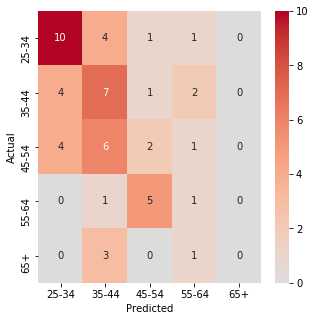

In [22]:
predictions = search.predict(age_X_test)

print("Accuracy: ", accuracy_score(age_y_test, predictions))
print(classification_report(age_y_test, predictions))
print(confusion_matrix(age_y_test, predictions))

confusion_matrix_heatmap(confusion_matrix(age_y_test,predictions), search.classes_)

<a id="ex"></a>
## Exercise (not assessed)

Try adding and improving the features used for age classification, and evaluate your results with different setups.


### Advanced tasks:

- You could try predicting the precise age with a regression model (the age is in the json metadata). See: https://dl.acm.org/citation.cfm?id=2107651.
- Or you could try predicting age and gender together, either mutli-class pairs, or through a classification tree, e.g. predict gender first, then narrowing age ranges.